# Data Exploration

Scopo di questo quaderno è di esplorare il dataset a disposizione, studiando come si distribuiscono le varie features, calcolare alcuni indicatori statistici ed individuare eventuali dati patologici.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
%%time

dati = np.load("Dataset/dati.npz")
X = dati["X"]
y = dati["y"]

print(X.shape)
print(y.shape)


(130064, 50)
(130064,)
CPU times: total: 141 ms
Wall time: 457 ms


# Verifica di consistenza

Verifico brevemente che i dati usati siano tutti validi, ovvero che non contengano `nan` oppure `inf`

In [3]:
print(f"Numero di nan presenti nei dati: {np.sum(np.isnan(X))}")
print(f"Numero di inf presenti nei dati: {np.sum(np.isinf(X))}")
print(f"Tipo dei dati: {X.dtype}")


Numero di nan presenti nei dati: 0
Numero di inf presenti nei dati: 0
Tipo dei dati: float64


Verifico se in qualche linea è presente un valore mancante oppure un campo vuoto

In [4]:
nSkip = 0
numCol = 50

with open("Dataset/MiniBooNE_PID.csv", "r") as f:
    for i, line in enumerate(f.readlines()):
        if i < nSkip: continue
        
        # if i == nSkip: 
        #     print(line)
        #     print(len(line.split(",")))
        
        lineSplit = line.split(",")
        
        if len(lineSplit) != numCol:
            print(f"Numero inconsistente di valori a linea {i}")
            
        if (""," ") in lineSplit:
            print(f"Campo vuoto a linea {i}")

# Distribuzione dei ground truth

## Distribuzione statistica d'insieme
Inizio a studiare le proporzioni con cui sono presenti le due classi all'interno del dataset. Ricordando che il vettore `y` delle classi vere l'ho costruito io come
```python
Ns = 36499
Nb = 93565

y = np.hstack((np.ones(Ns), np.zeros(Nb)))
```
vedo già che il dataset non è esattamente bilanciato, contenendo molti più eventi di *background* rispetto a quelli di *segnale*

Numero di classi con target 0: 93565 -- 0.72 %
Numero di classi con target 1: 36499 -- 0.28 %


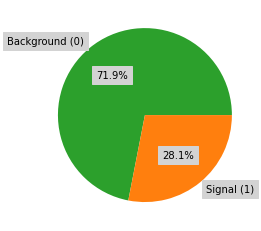

In [5]:
# Totale di eventi per le due classi
tot0 = (y==0).sum()
tot1 = (y==1).sum()

# Percentuali
percent0 = tot0 / (tot0 + tot1)
percent1 = tot1 / (tot0 + tot1)


print(f"Numero di classi con target 0: {tot0} -- {percent0:.2f} %")
print(f"Numero di classi con target 1: {tot1} -- {percent1:.2f} %")


# Pie chart
fig, ax = plt.subplots()

ax.pie([tot0, tot1], labels = ("Background (0)", "Signal (1)"), autopct='%1.1f%%',
       colors = ("tab:green", "tab:orange"), textprops = {"color":"k", "backgroundcolor":"lightgrey"})

fig.savefig("../LATEX/FIGURE/01_PieChart.pdf", format = "pdf", bbox_inches = "tight")

plt.show()

## Distribuzione all'interno del dataset
Vado ora a studiare la distribuzione delle classi da classificare all'interno del dataset. Avendo costruito io il vettore come descritto prima, non mi devo stupire di avere prima tutti gli eventi di segnale e poi tutti quelli di rumore.

Per evitare di introdurre bias nelle fasi di training/test sarà necessario operare un reshuffle dei dati.

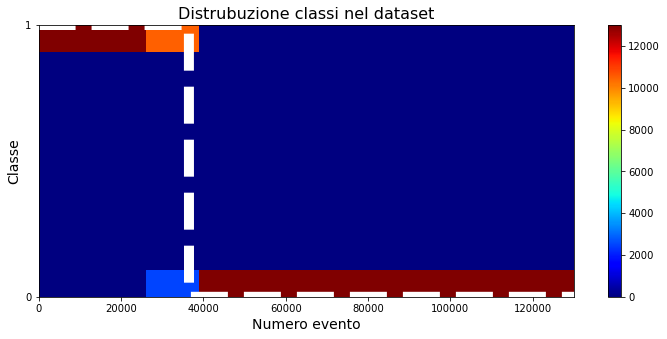

In [6]:
# Indice degli eventi (0, 1, 2....)
timeVect = np.arange(0, X.shape[0], step = 1)

fig, ax = plt.subplots()
fig.set_size_inches(12,5)

h = ax.hist2d(timeVect, y, cmap = "jet")

ax.plot(timeVect, y, c = "w", lw = 10, ls = "--")


ax.set_xlabel("Numero evento", fontsize = 14)
ax.set_ylabel("Classe", fontsize = 14)

ax.set_title("Distrubuzione classi nel dataset", fontsize = 16)

ax.set_yticks((0,1))



fig.colorbar(h[3], ax = ax)

#fig.savefig("../LATEX/FIGURE/01_hist2d.pdf", format = "pdf")


plt.show()

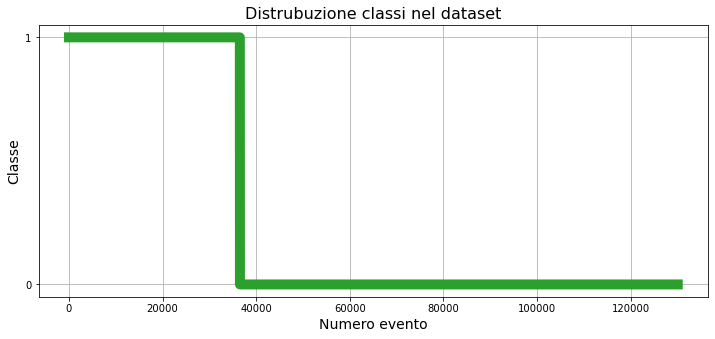

In [7]:
# Indice degli eventi (0, 1, 2....)
timeVect = np.arange(0, X.shape[0], step = 1)

fig, ax = plt.subplots()
fig.set_size_inches(12,5)

#h = ax.hist2d(timeVect, y, cmap = "jet")

ax.plot(timeVect, y, c = "tab:green", lw = 10, ls = "-")#, label = "Classe di appartenenza")


ax.set_xlabel("Numero evento", fontsize = 14)
ax.set_ylabel("Classe", fontsize = 14)

ax.set_title("Distrubuzione classi nel dataset", fontsize = 16)

ax.set_yticks((0,1))

ax.grid()



fig.savefig("../LATEX/FIGURE/01_hist2d.pdf", format = "pdf")


plt.show()

(copio da vecchio repo)
- Notiamo che la prima metà dei dati è relativa alla classe "0", mentre la seconda metà alla classe "1"
- In questo dataset non esiste (fortunatamente) una feature relativa al numero di evento o al tempo. In caso contrario avrei dovuto dropparla. Sarebbe stata artificiosamente troppo informativa, ma non avrei imparato veramente dai dati...
- Tuttavia il dataset non potrà essere suddiviso in TrS e TeS banalmente prendendo i primi $n$ eventi come TrS ed i restanti ultimi $N-n$ come TeS: un k-fold validation potrebbe sicuramente contribuire a limitare i bias, ma una operazione di reshuffling sarebbe opportuna

# Distribuzioni delle features
Inizio a studiare la distribuzione statistica delle features

In [8]:
# Ingrandisco label per plot relazione
import matplotlib as mpl
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

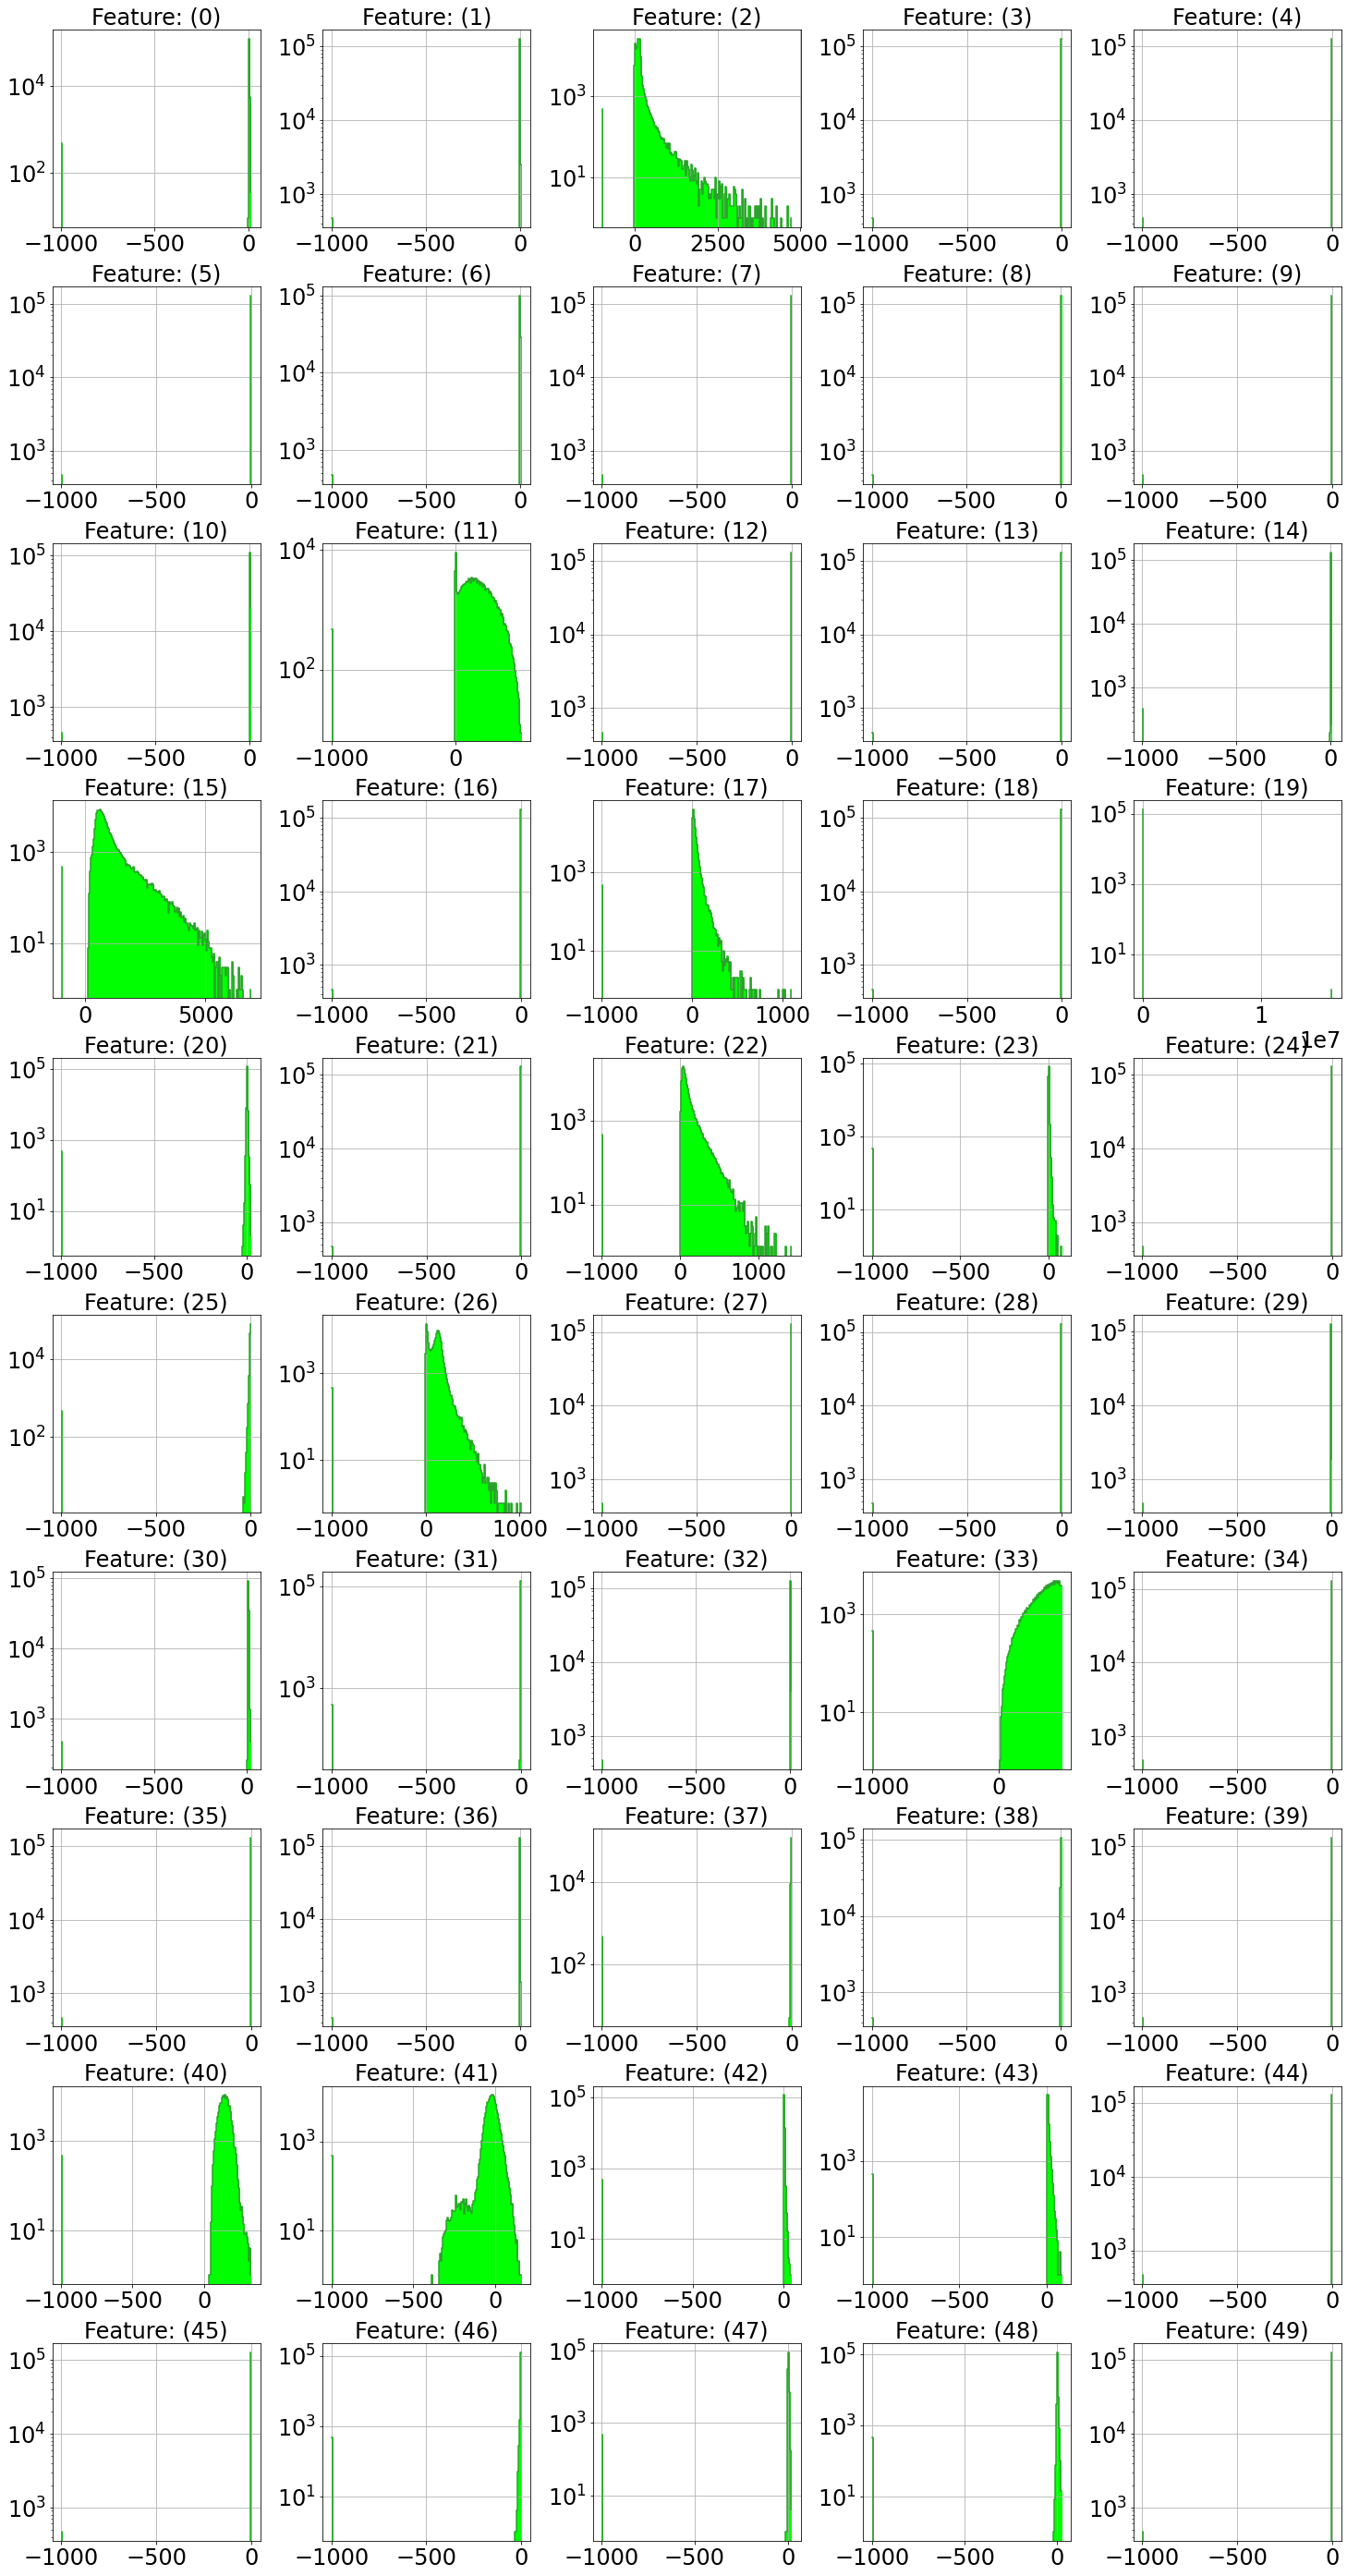

CPU times: total: 14.9 s
Wall time: 15.9 s


In [9]:
%%time

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25,50)
fig.subplots_adjust(hspace = .3, wspace = .3)
ax = ax.flatten()

for i in range(X.shape[1]):
    h, bins = np.histogram(X[:,i], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
    ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
    
    ax[i].set_yscale("log")
    

    
    
    ax[i].grid()
    #ax[i].legend()
    ax[i].set_title(f"Feature: ({i})", fontsize = 24)
    

fig.savefig("../LATEX/FIGURE/01-dist-features.pdf", format = "pdf", bbox_inches = "tight")
    
plt.show()
    

Noto che molti istogrammi presentano una sorta di bin unico a circa $-1000$, e visibilmente staccato dal resto della distribuzione. Tale valore rappresenta sicuramente un qualche valore da escludere

In [10]:
X[:,0][X[:,0] < -200]

array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999.,

Tali valori patologici sono una sfilza di $-999$: provvedo ad escludere le righe che contengono almeno un tale valore

In [11]:
matrixBad = X == -999
rowBad = np.any(matrixBad, axis = 1)
print(rowBad.shape)

print(f"Le righe patologiche sono {rowBad.sum()}")

(130064,)
Le righe patologiche sono 468


Provo a studiare come sono distribuiti gli errori

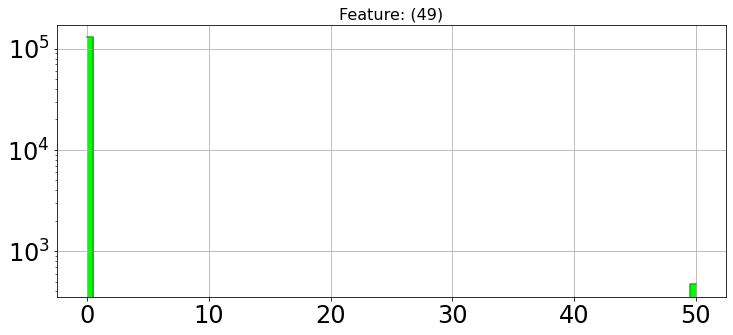

In [12]:
nErrPerRow = np.sum(matrixBad, axis = 1)


fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

# h, bins = np.histogram(nErrPerRow, bins = 40)
# binc = bins[:-1] + (bins[1] - bins[0])/2

h = np.bincount(nErrPerRow)
binc = np.arange(0, h.shape[0]) 

ax.plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
ax.fill_between(binc, h, step = "mid", color = "lime", alpha = 1)

ax.set_yscale("log")
ax.grid()
ax.set_title(f"Feature: ({i})", fontsize = 16)
    
plt.show()

In [13]:
for hh, bb in zip(h, binc):
    if hh > 0:
        print(hh, bb)

129596 0
468 50


Quelle rare volte (468) in cui ho dei $-999$, lo ho in tutte le features, in altre parole ho un'intera riga non valida. Provo a chiedermi quale sia la classe vera associata alle righe patologiche.

In [14]:
yBad = y[rowBad]

print(yBad.shape)

print(f"Numero di eventi difettosi associati alla classe segnale: {np.sum(yBad==1)}")
print(f"Numero di eventi difettosi associati alla classe Background: {np.sum(yBad==0)}")


(468,)
Numero di eventi difettosi associati alla classe segnale: 11
Numero di eventi difettosi associati alla classe Background: 457


Noto che appartiene quasi sempre alle classi di background, che sono quelle che erano presenti in maggioranza nel dataset.  
Rimuovo dunque le righe patologiche

In [15]:
X999 = X[np.logical_not(rowBad)]
y999 = y[np.logical_not(rowBad)]
#X999 = X[~rowBad]

print(X999.shape)

# Verifico che somma patologici + Somma ev tenuti sia uguale alla somma di partenza
print(f"X999.shape: {X999.shape[0]}\trowBad.sum(): {rowBad.sum()}\nSomma: {X999.shape[0] + rowBad.sum()}\nX.shape: {X.shape}")
print(f"Le righe scartate sono il {rowBad.sum()/X.shape[0] * 100 :.2f} % del dataset")

(129596, 50)
X999.shape: 129596	rowBad.sum(): 468
Somma: 130064
X.shape: (130064, 50)
Le righe scartate sono il 0.36 % del dataset


Posso allora riguardare la distribuzione delle features dopo aver rimosso questi dati

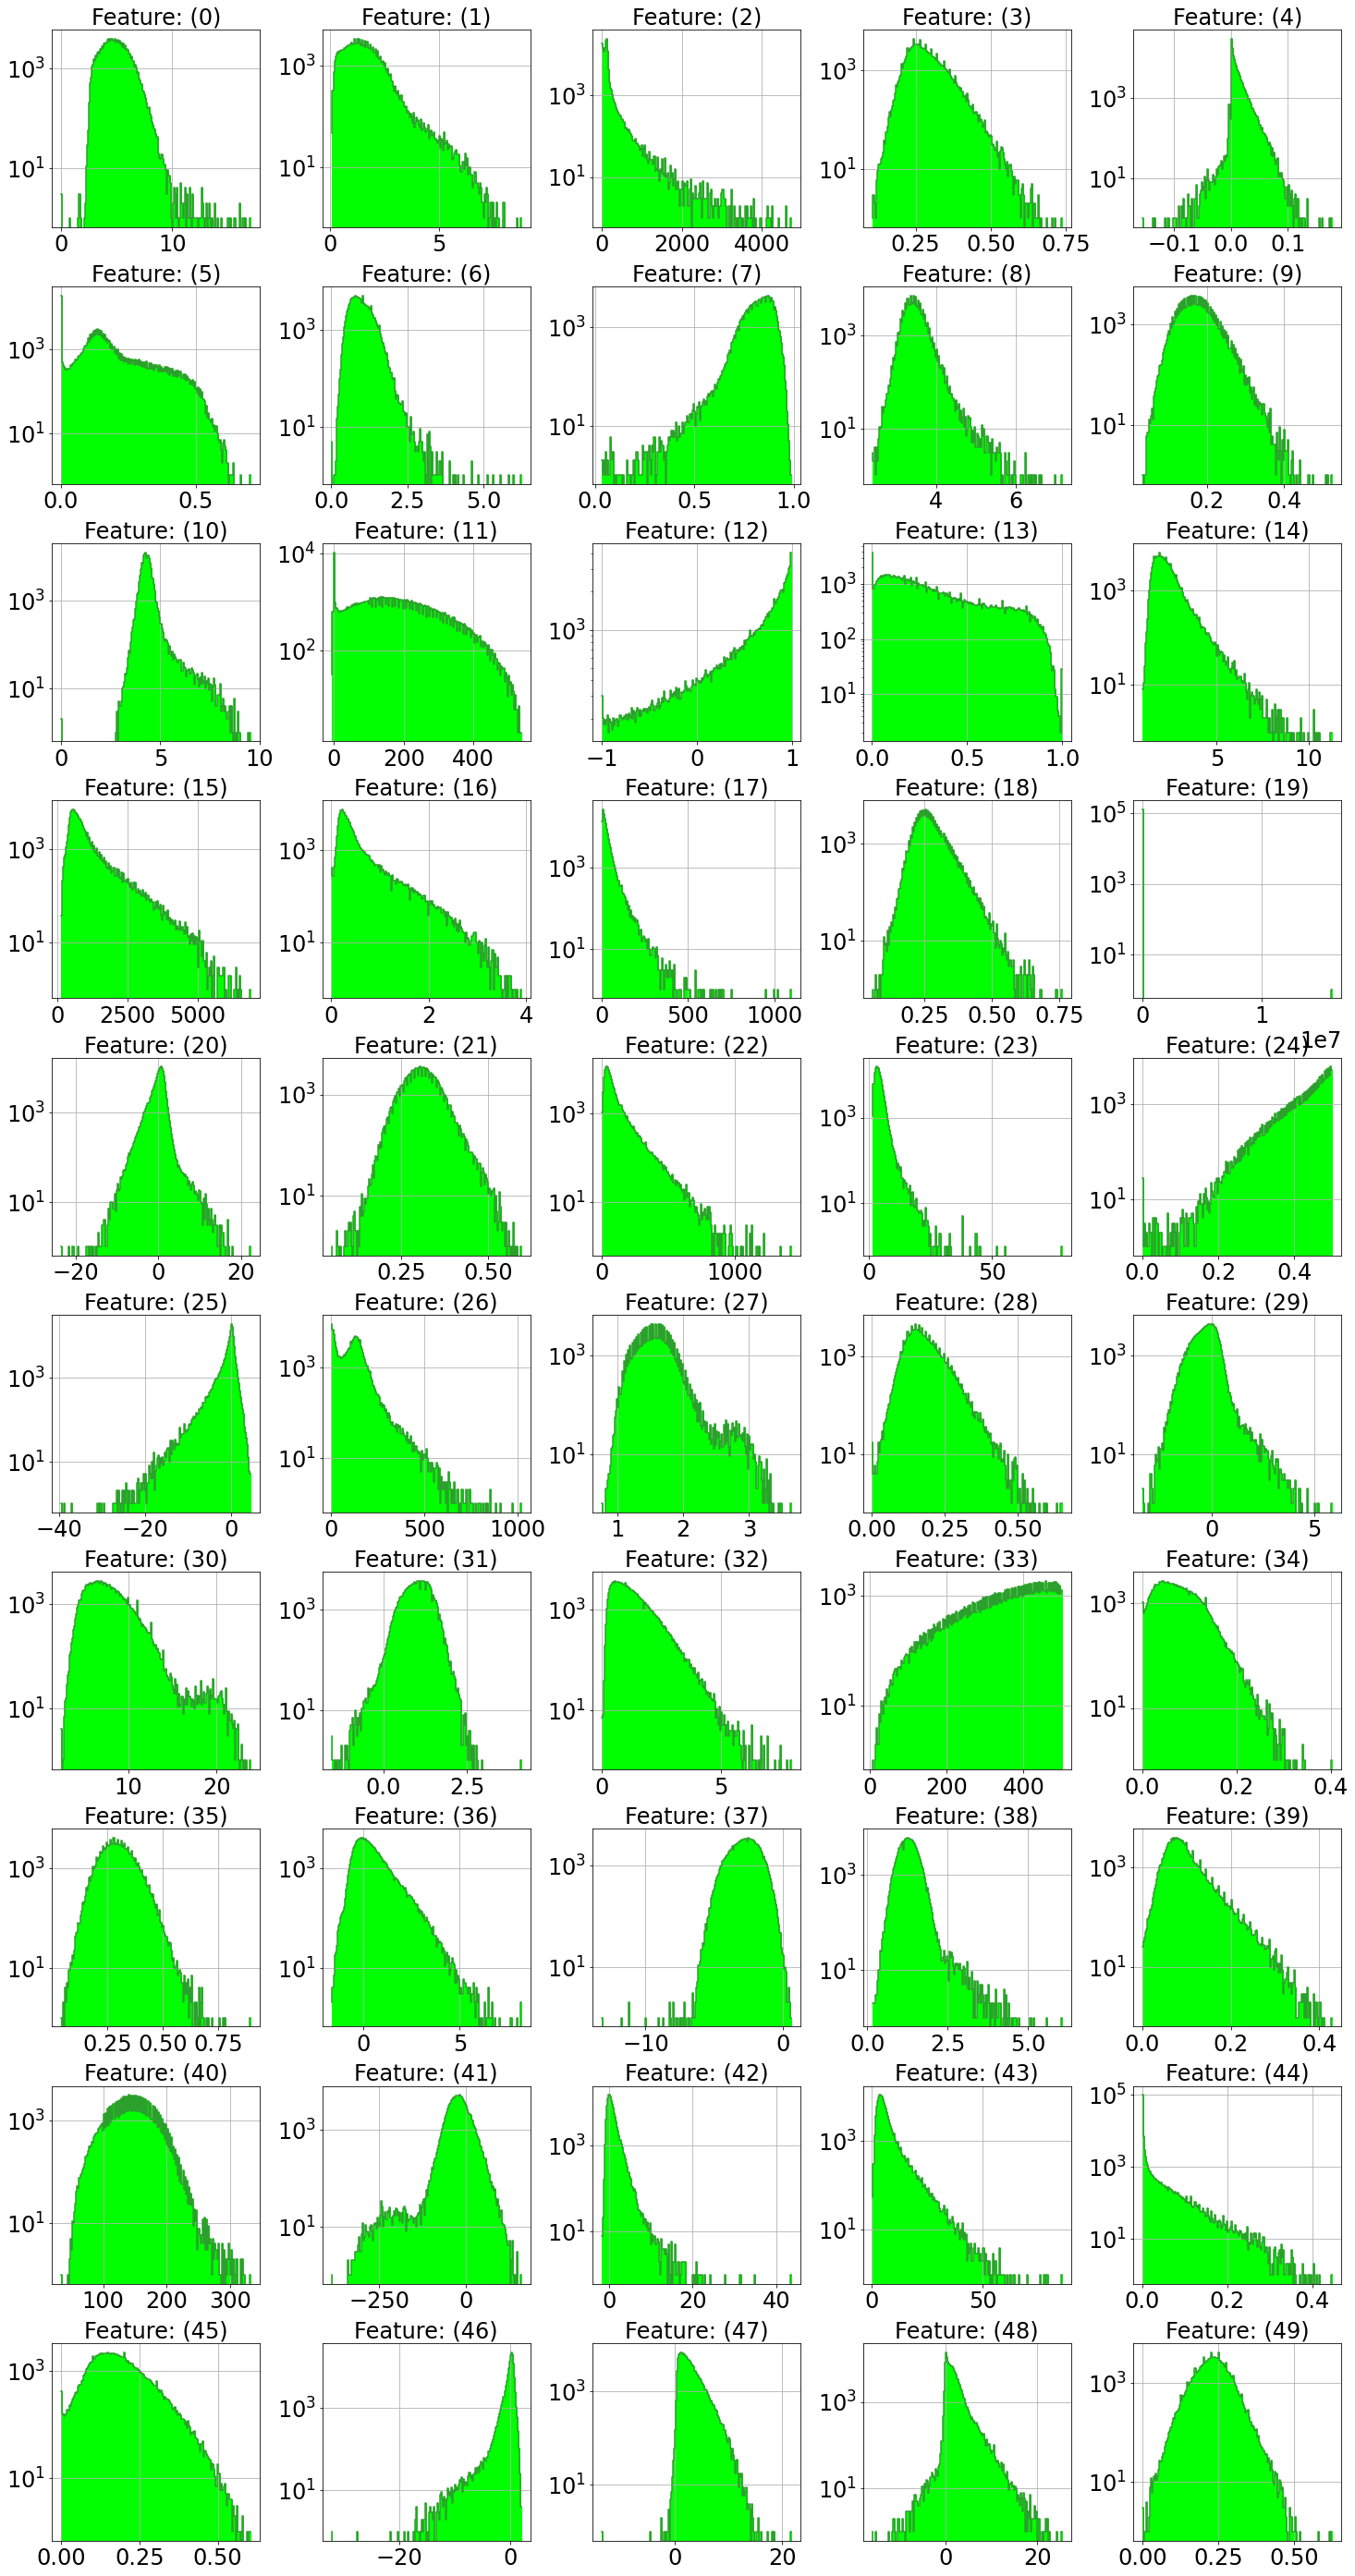

CPU times: total: 7.59 s
Wall time: 7.68 s


In [16]:
%%time

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25,50)
fig.subplots_adjust(hspace = .3, wspace = .3)
ax = ax.flatten()

for i in range(X999.shape[1]):
    h, bins = np.histogram(X999[:,i], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
    ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
    
    ax[i].set_yscale("log")
    

    
    
    ax[i].grid()
    #ax[i].legend()
    ax[i].set_title(f"Feature: ({i})", fontsize = 24)
    
    
fig.savefig("../LATEX/FIGURE/01-dist-features-999.pdf", format = "pdf", bbox_inches = "tight")
    
plt.show()
    

La maggior parte dei problemi sono stati risolti, solamente la feature 19 mantiene ancora una distribuzione strana. provo a studiarla più in dettaglio

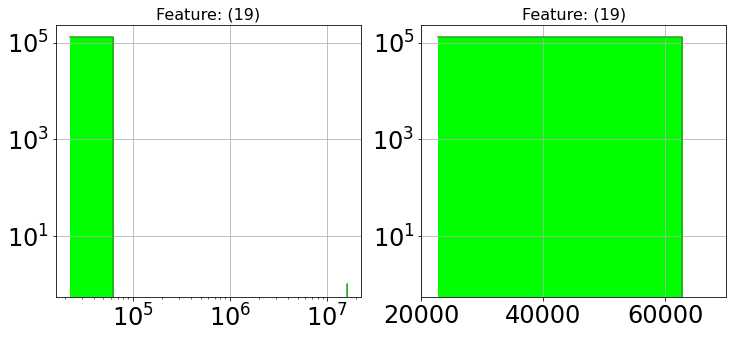

CPU times: total: 406 ms
Wall time: 410 ms


In [17]:
%%time

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 5)

for i in range(2):
    h, bins = np.histogram(X999[:,19], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2

    ax[i].plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
    ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
    ax[i].set_yscale("log")


    ax[i].grid()
    #ax[i].legend()
    ax[i].set_title(f"Feature: ({19})", fontsize = 16)

# >>
ax[0].set_xscale("log")
ax[1].set_xlim(2e4, 7e4)

#fig.savefig("../LATEX/FIGURE/01-feat-19.pdf", format = "pdf", bbox_inches = "tight")

    
plt.show()
    

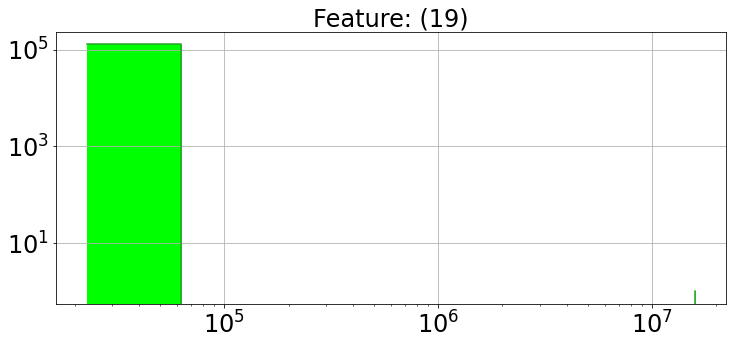

CPU times: total: 641 ms
Wall time: 693 ms


In [18]:
%%time

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

h, bins = np.histogram(X999[:,19], bins = 200)
binc = bins[:-1] + (bins[1] - bins[0])/2

ax.plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
ax.fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
ax.set_yscale("log")


ax.grid()
#ax[i].legend()
ax.set_title(f"Feature: ({19})", fontsize = 24)

# >>
ax.set_xscale("log")
#ax[1].set_xlim(2e4, 7e4)

fig.savefig("../LATEX/FIGURE/01-feat-19.pdf", format = "pdf", bbox_inches = "tight")

    
plt.show()
    

Pare esserci un singolo punto punto a circa 1.6e7 nettamente staccato dal resto della distribuzione. Anch'esso pare un problema ==> Lo rimuovo

In [19]:
tmpLogic = X999[:,19] > 1e5

print(tmpLogic.shape)
print(tmpLogic.sum())
print(X999[:,19][tmpLogic])

(129596,)
1
[16000000.]


Butto via quell'unico valore

In [20]:
np.sum(np.logical_not(tmpLogic))

129595

In [21]:
Xfinal = X999[np.logical_not(tmpLogic)]
yfinal = y999[np.logical_not(tmpLogic)]

print(Xfinal.shape)

(129595, 50)


Riguardo finalmente la distribuzione delle features con anche questa modifica

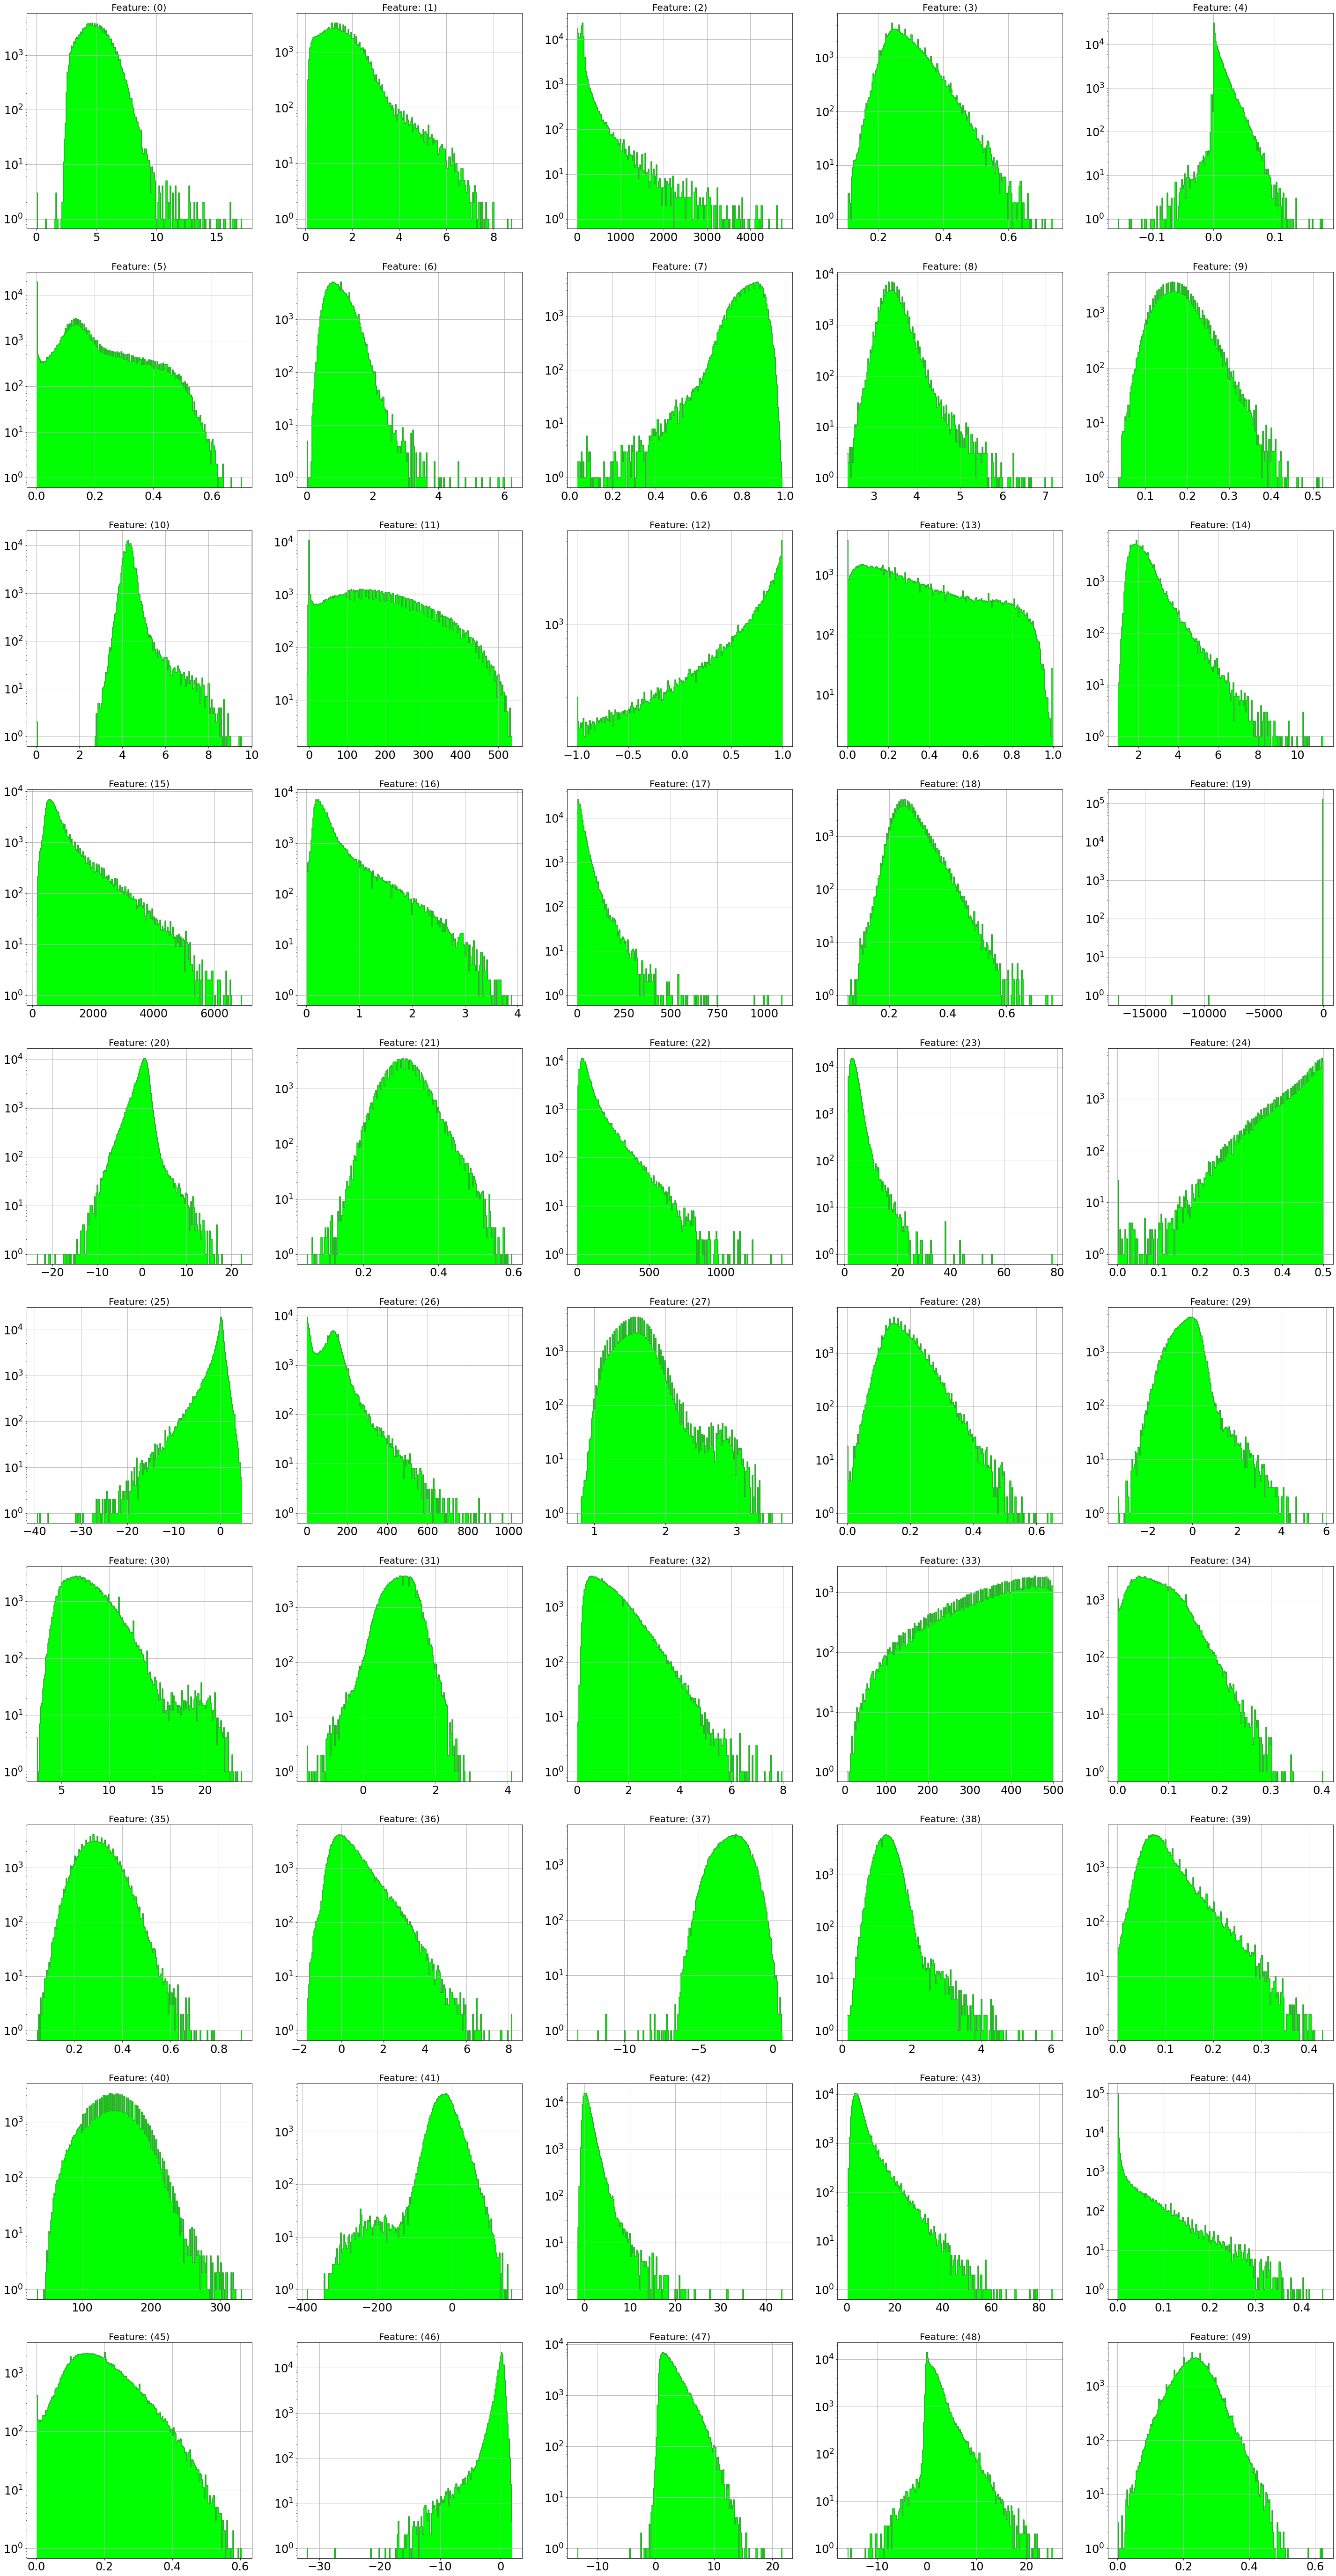

CPU times: total: 15.2 s
Wall time: 27.9 s


In [22]:
%%time

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(50, 100)
ax = ax.flatten()

for i in range(Xfinal.shape[1]):
    h, bins = np.histogram(Xfinal[:,i], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
    ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
    
    ax[i].set_yscale("log")
    

    
    
    ax[i].grid()
    #ax[i].legend()
    ax[i].set_title(f"Feature: ({i})", fontsize = 20)
    
plt.show()
    

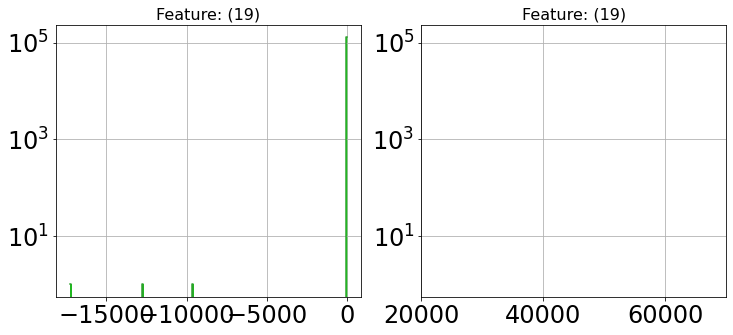

CPU times: total: 359 ms
Wall time: 364 ms


In [23]:
%%time

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 5)

for i in range(2):
    h, bins = np.histogram(Xfinal[:,19], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2

    ax[i].plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
    ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
    ax[i].set_yscale("log")


    ax[i].grid()
    #ax[i].legend()
    ax[i].set_title(f"Feature: ({19})", fontsize = 16)

# >>
#ax[0].set_xscale("log")
ax[1].set_xlim(2e4, 7e4)
    
plt.show()
    

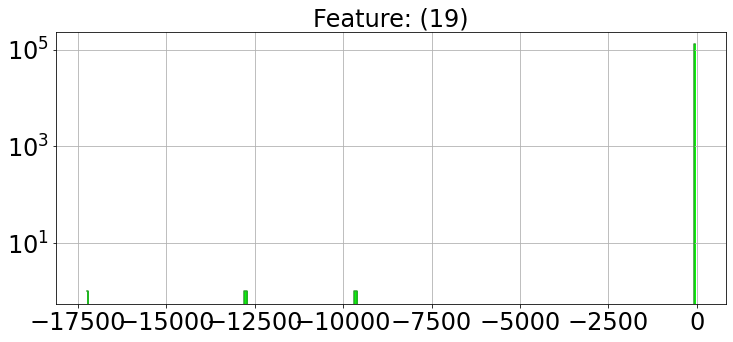

CPU times: total: 312 ms
Wall time: 361 ms


In [24]:
%%time

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

h, bins = np.histogram(Xfinal[:,19], bins = 200)
binc = bins[:-1] + (bins[1] - bins[0])/2

ax.plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
ax.fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
ax.set_yscale("log")


ax.grid()
#ax[i].legend()
ax.set_title(f"Feature: ({19})", fontsize = 24)

# >>
#ax[1].set_xlim(2e4, 7e4)

fig.savefig("../LATEX/FIGURE/01-feat-19-2.pdf", format = "pdf", bbox_inches = "tight")

    
plt.show()
    

In [25]:
tmpLogicNew = Xfinal[:,19] < -2000

print(tmpLogicNew.sum()) 
print(np.sum( X999[:,19] < -2000 ))


3
3


Questa operazione ha permesso di evidenziare tre nuovi punti patologici, che provvedo a rimuovere

In [26]:
XfinalNew = Xfinal[np.logical_not(tmpLogicNew)]
yfinalNew = yfinal[np.logical_not(tmpLogicNew)]

print(XfinalNew.shape)

(129592, 50)


Sono pronto a riguardare le distribuzioni delle features

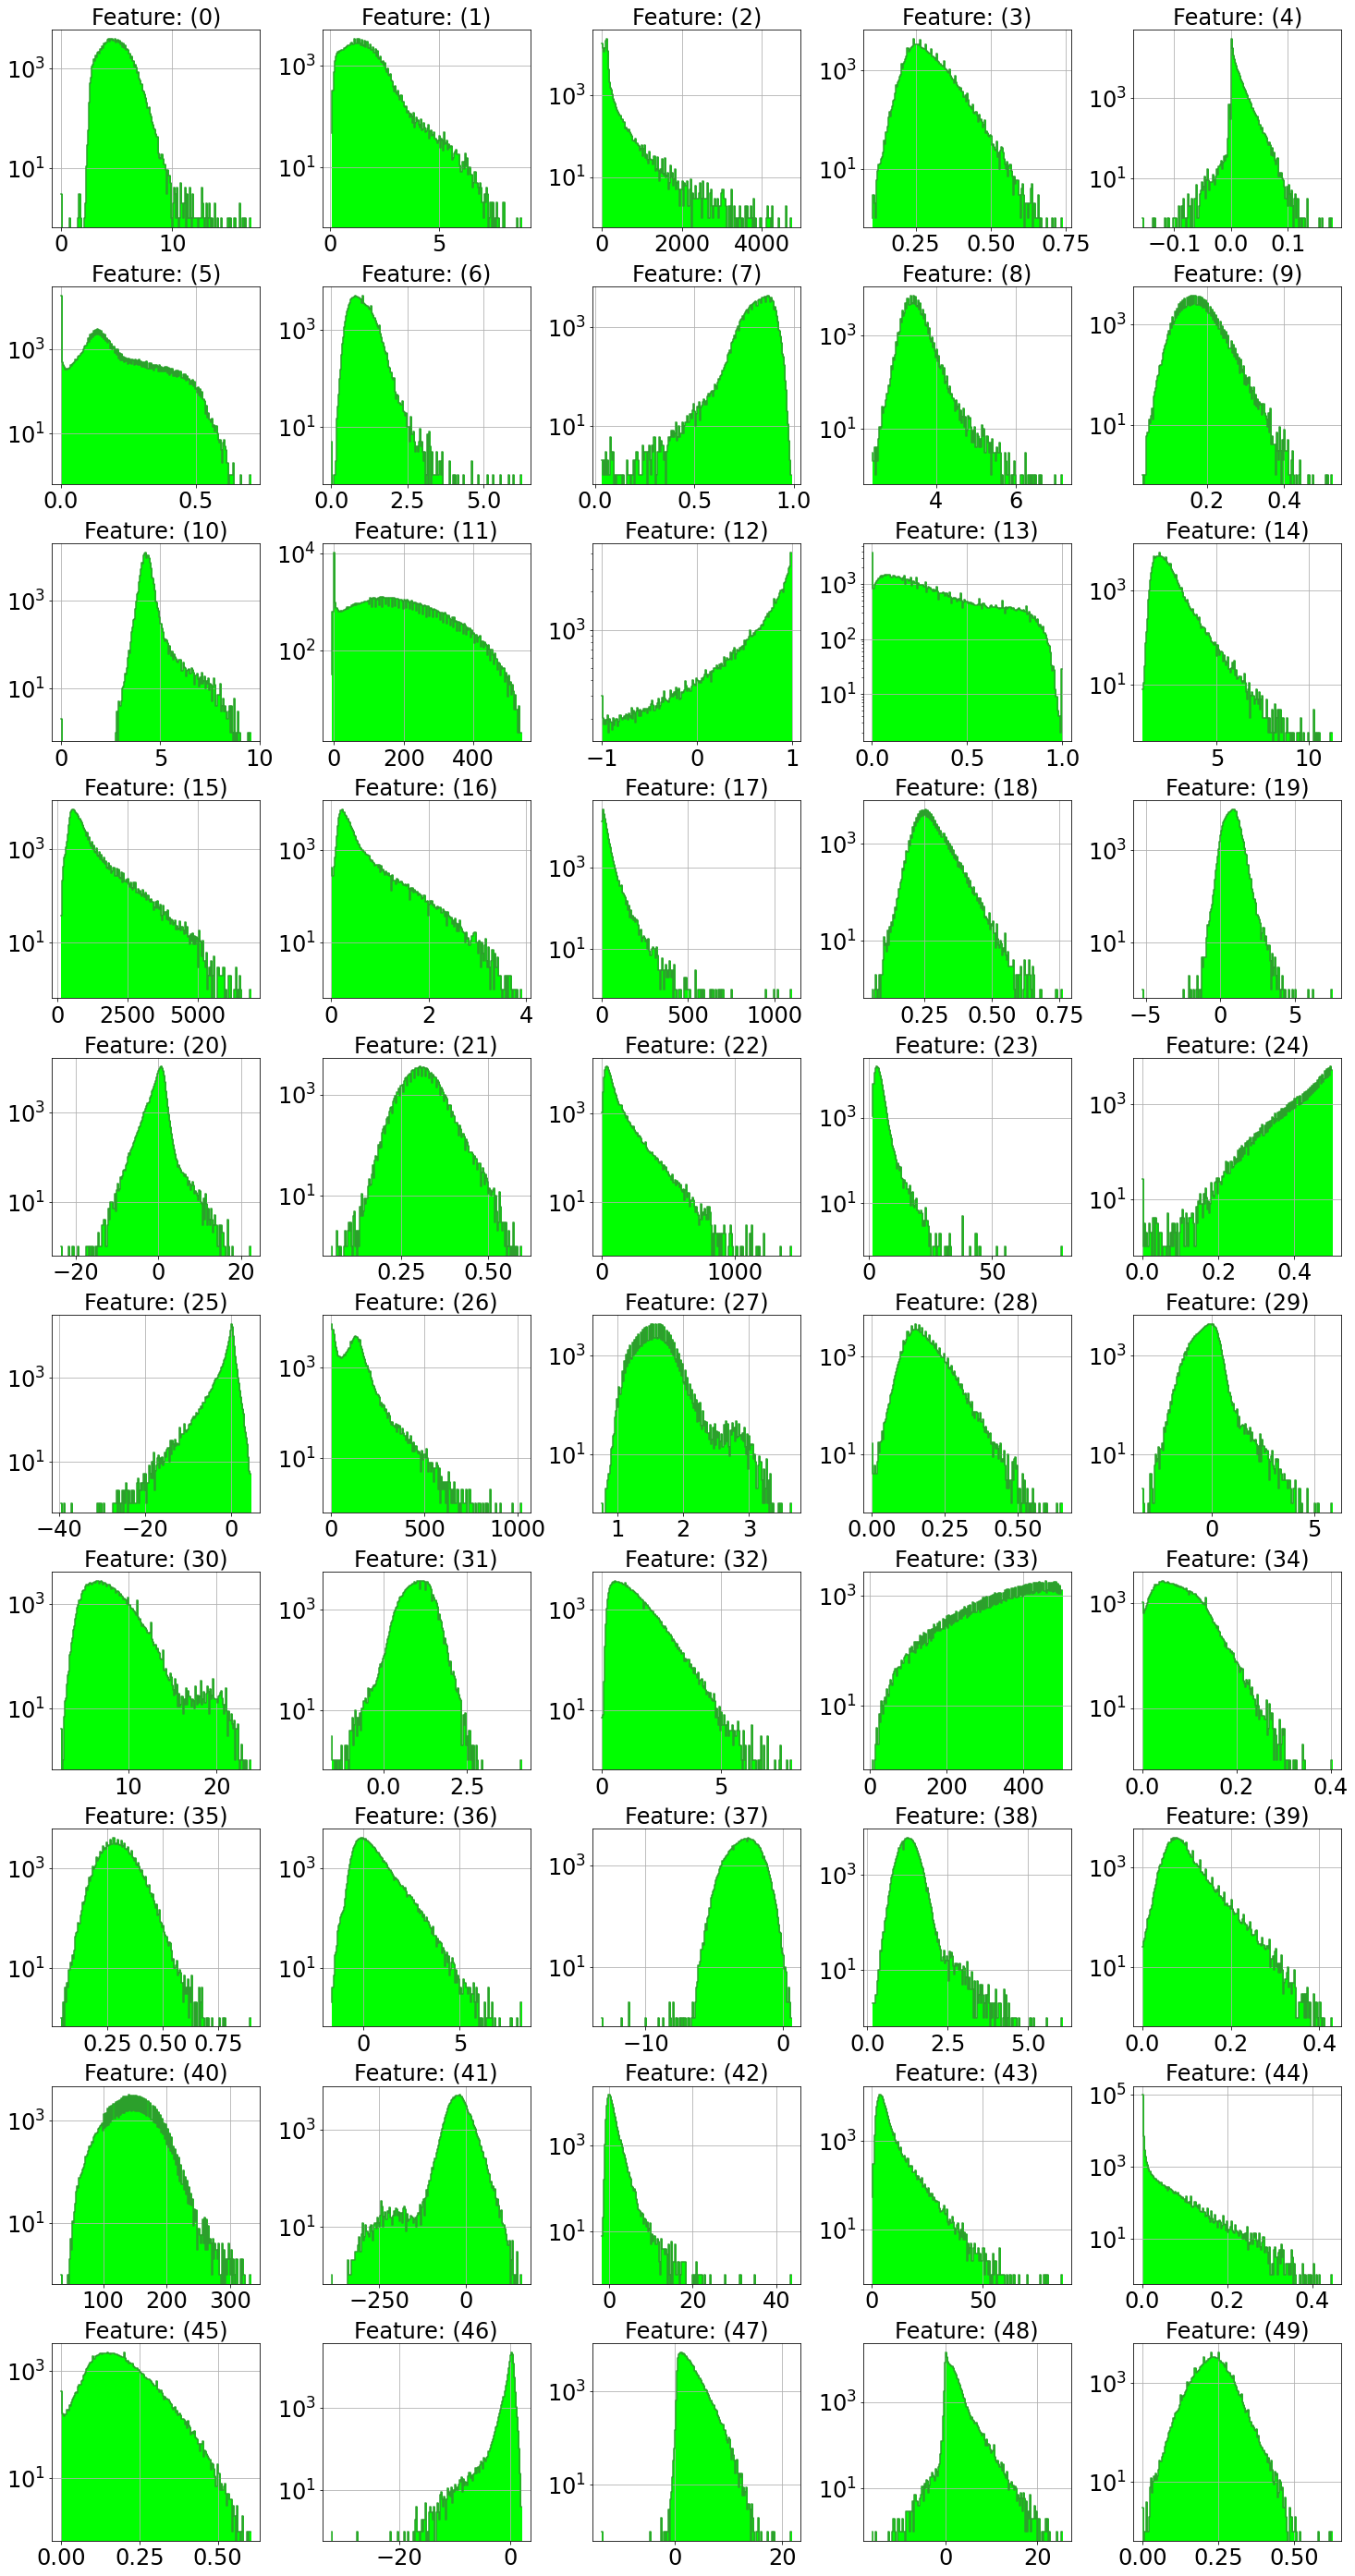

CPU times: total: 8.7 s
Wall time: 9.2 s


In [27]:
%%time

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25,50)
fig.subplots_adjust(hspace = .3, wspace = .3)
ax = ax.flatten()

for i in range(Xfinal.shape[1]):
    h, bins = np.histogram(XfinalNew[:,i], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
    ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
    
    ax[i].set_yscale("log")
    

    
    
    ax[i].grid()
    #ax[i].legend()
    ax[i].set_title(f"Feature: ({i})", fontsize = 24)
    
    
fig.savefig("../LATEX/FIGURE/01-dist-features-finale.pdf", format = "pdf", bbox_inches = "tight")

plt.show()
    

# Esporto i dati

Ora che ho rimosso tutti gli eventi patologici posso finalmente esportare i dati, e saranno loro quelli da usare per le analisi

In [28]:
np.savez("Dataset/dati_puliti.npz", X = XfinalNew, y = yfinalNew)

# Load pulito dei nuovi dati

In [29]:
del X, y

In [30]:
%%time

dati = np.load("Dataset/dati_puliti.npz")
X = dati["X"]
y = dati["y"]

print(X.shape)
print(y.shape)


(129592, 50)
(129592,)
CPU times: total: 78.1 ms
Wall time: 87 ms


Posso ora valutare le vere proporzioni delle classi nel dataset, e notare che sono rimaste pressoché invariate, avendo rimosso una piccola porzione dei dati.

Numero di classi con target 0: 93104 -- 0.72 %
Numero di classi con target 1: 36488 -- 0.28 %


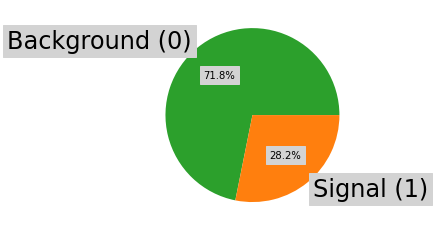

In [31]:
# Totale di eventi per le due classi
tot0 = (y==0).sum()
tot1 = (y==1).sum()

# Percentuali
percent0 = tot0 / (tot0 + tot1)
percent1 = tot1 / (tot0 + tot1)


print(f"Numero di classi con target 0: {tot0} -- {percent0:.2f} %")
print(f"Numero di classi con target 1: {tot1} -- {percent1:.2f} %")


# Pie chart
fig, ax = plt.subplots()

ax.pie([tot0, tot1], labels = ("Background (0)", "Signal (1)"), autopct='%1.1f%%',
       colors = ("tab:green", "tab:orange"), textprops = {"color":"k", "backgroundcolor":"lightgrey"})

#fig.savefig("../LATEX/FIGURE/01_PieChart.pdf", format = "pdf")

plt.show()

# Distribuzione delle features, per classi
Plotto gli istogrammi, normalizzati al rispettivo numero di entries, per ciascuna feature, al variare del ground truth

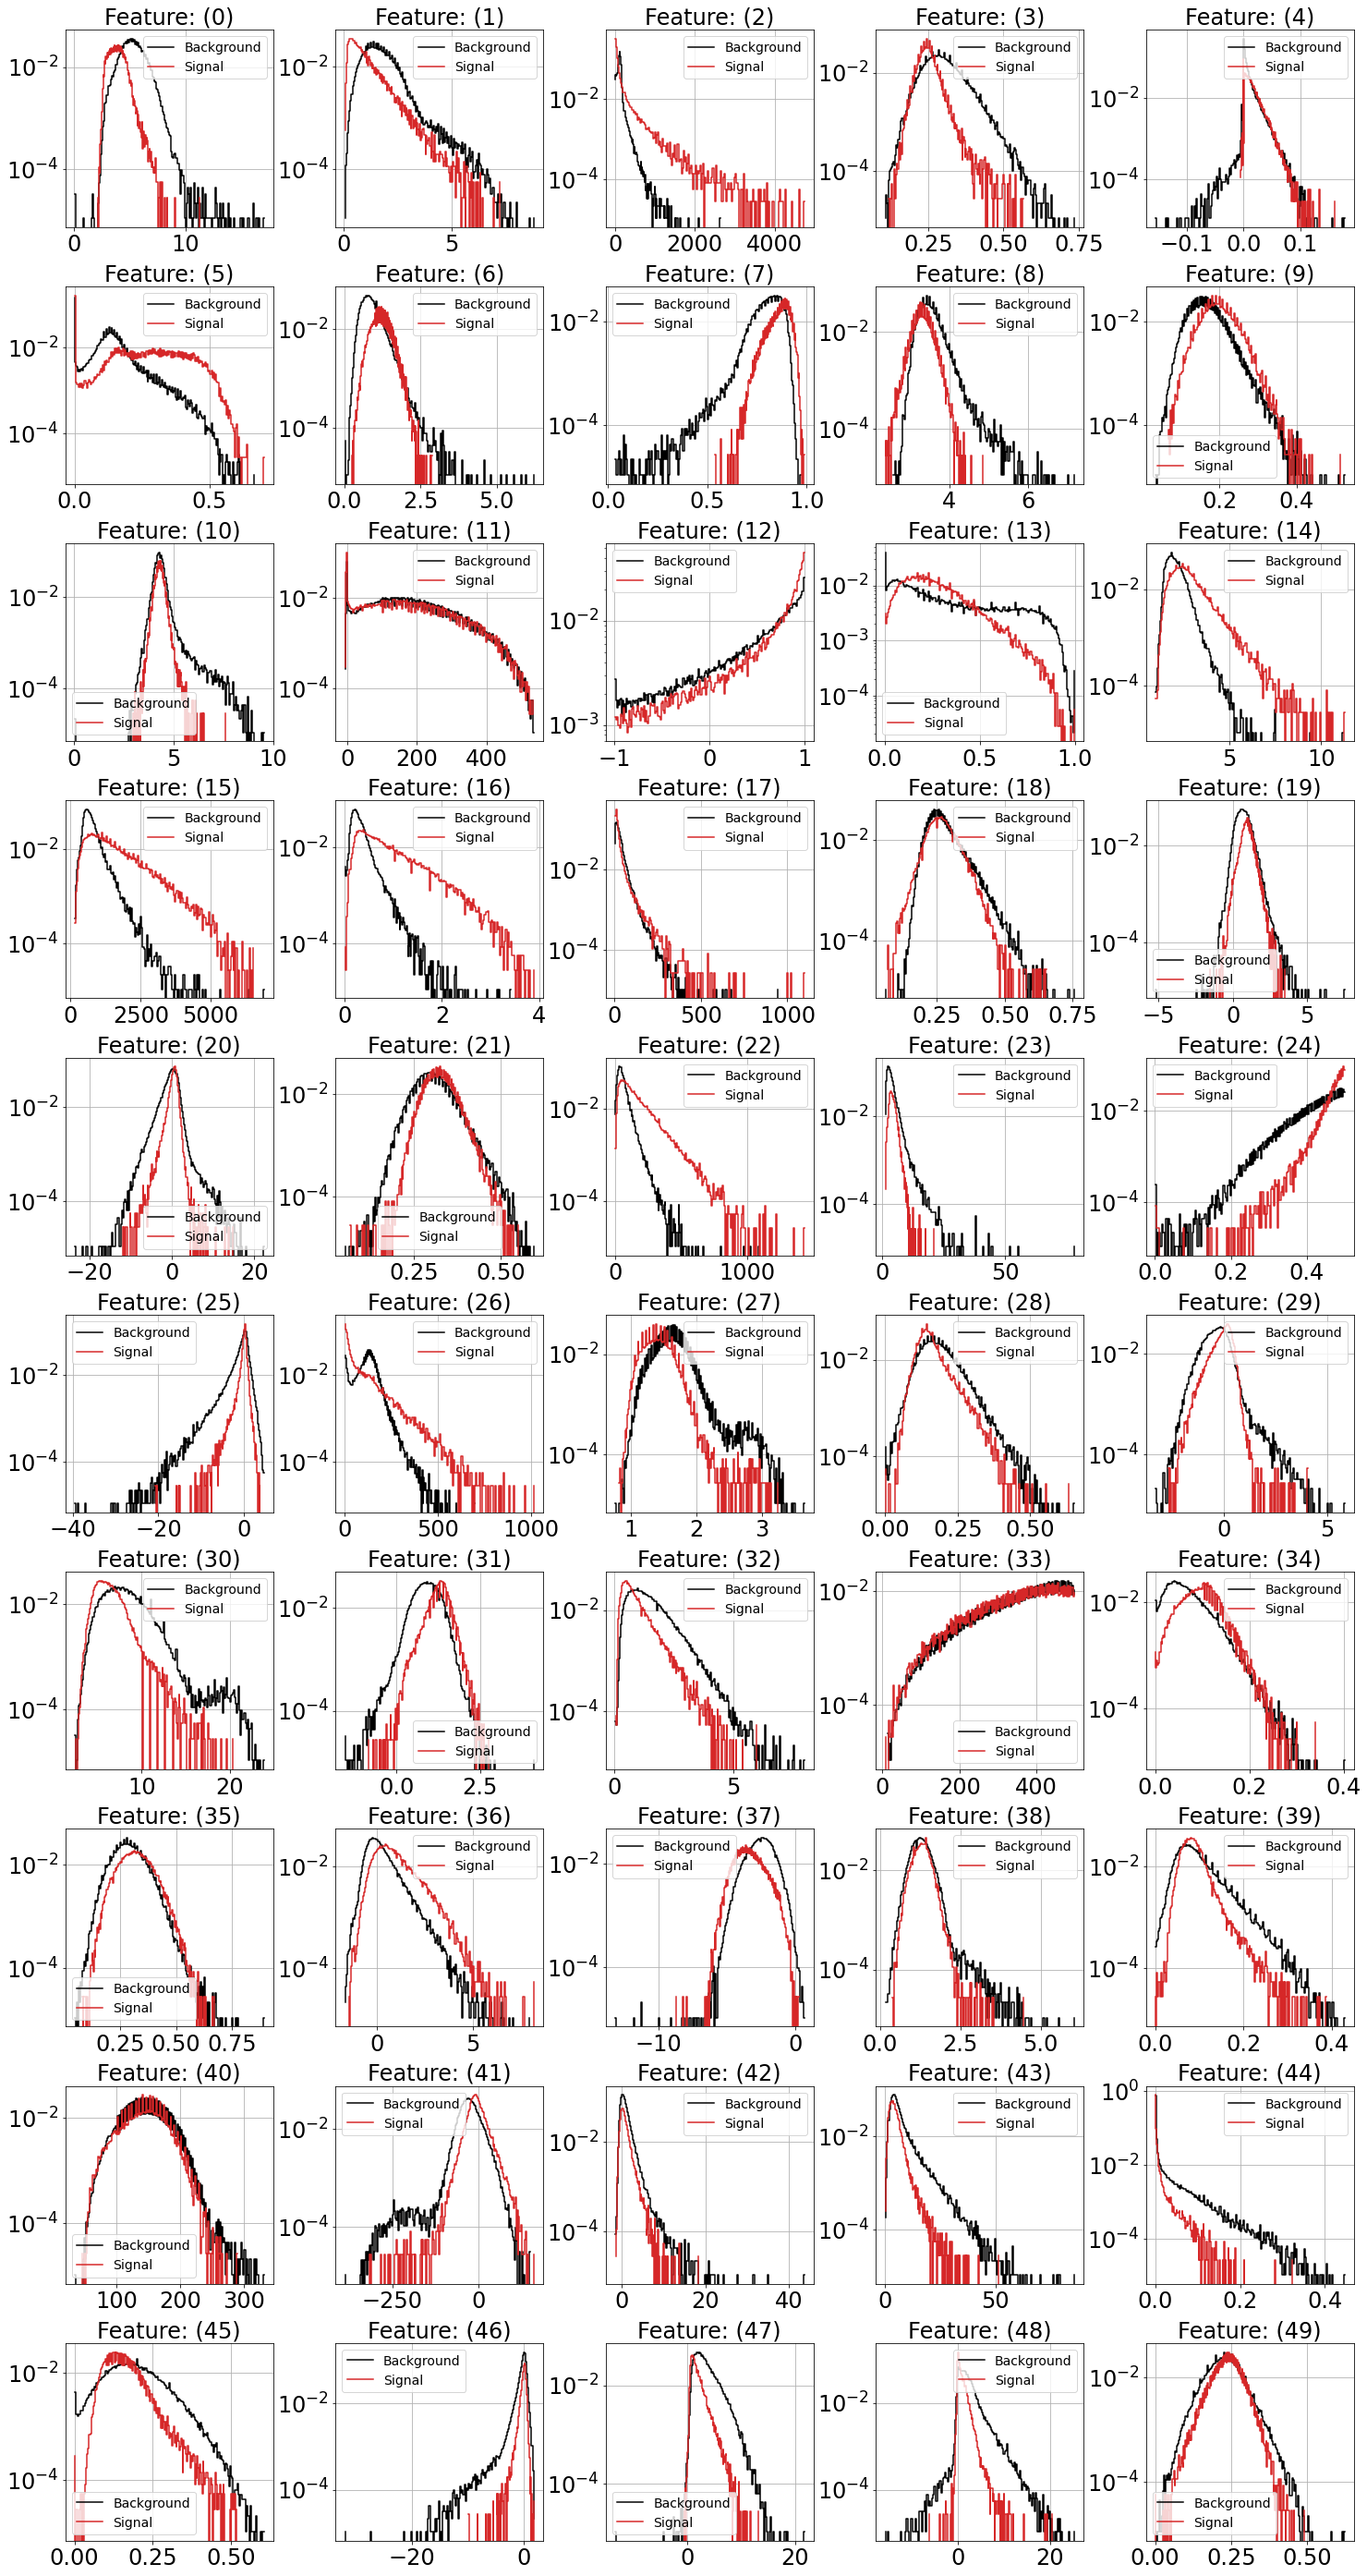

CPU times: total: 11 s
Wall time: 12.2 s


In [32]:
%%time

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25,50)
fig.subplots_adjust(hspace = .3, wspace = .3)
ax = ax.flatten()

for i in range(Xfinal.shape[1]):
    h, bins = np.histogram(X[:,i][y==0], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h/np.sum(h), ds = "steps-mid", label = "Background", c = "k")
    #ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
    
    h, bins = np.histogram(X[:,i][y==1], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h/np.sum(h), ds = "steps-mid", label = "Signal", c = "tab:red")
    #ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)
    
    ax[i].set_yscale("log")
    

    
    
    ax[i].grid()
    ax[i].legend(fontsize = 14)
    ax[i].set_title(f"Feature: ({i})", fontsize = 24)
    
    
fig.savefig("../LATEX/FIGURE/01-dist-features-classi.pdf", format = "pdf", bbox_inches = "tight")

plt.show()
    